# Classifier Chain

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain

In [3]:
data_raw = pd.read_csv('../data/curated/combined_data_div_binned.csv')
data_reduced = pd.read_csv('../data/curated/combined_data_div_binned_reduced.csv')
label = pd.read_csv('../data/curated/combined_label.csv')
significant_features = pd.read_csv('../data/curated/significant_features.csv')
significant_features = significant_features['0'].tolist()
label = label.iloc[:, 0:2]

data_selected = data_raw[significant_features]
data_div = data_selected.filter(regex='div')
data_original = data_selected.drop(data_div.columns, axis=1)


In [4]:

X_train, X_test, Y_train, Y_test = train_test_split(data_selected, label, test_size=0.2, random_state=0)

# Fit an independent logistic regression model for each class using the
# OneVsRestClassifier wrapper.
base_lr = LogisticRegression()
ovr = OneVsRestClassifier(base_lr)
ovr.fit(X_train, Y_train)
Y_pred_ovr = ovr.predict(X_test)
ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr, average="samples")

# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(base_lr, order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(Y_test, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(
    Y_test, Y_pred_ensemble >= 0.5, average="samples"
)

model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = (
    "Independent",
    "Chain 1",
    "Chain 2",
    "Chain 3",
    "Chain 4",
    "Chain 5",
    "Chain 6",
    "Chain 7",
    "Chain 8",
    "Chain 9",
    "Chain 10",
    "Ensemble",
)

x_pos = np.arange(len(model_names))

/Users/yulindong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yulindong/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [6]:
# check model recall, precision and accuracy
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

recall = recall_score(Y_test, Y_pred_ensemble >= 0.5, average="samples")
precision = precision_score(Y_test, Y_pred_ensemble >= 0.5, average="samples")
accuracy = accuracy_score(Y_test, Y_pred_ensemble >= 0.5)

print("recall: ", recall)
print("precision: ", precision)
print("accuracy: ", accuracy)

recall:  0.30689655172413793
precision:  0.31912225705329156
accuracy:  0.580564263322884


/Users/yulindong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yulindong/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
Y_pred_ensemble >= 0.5

array([[False, False],
       [False,  True],
       [False, False],
       ...,
       [False,  True],
       [False,  True],
       [False, False]])

In [7]:
Y_test

,FYZ-IgM,甲流
451,0,1
5660,0,0
2278,1,0
4273,0,1
2417,0,1
...,...,...
3407,0,1
2707,1,0
1150,0,1
7746,0,0


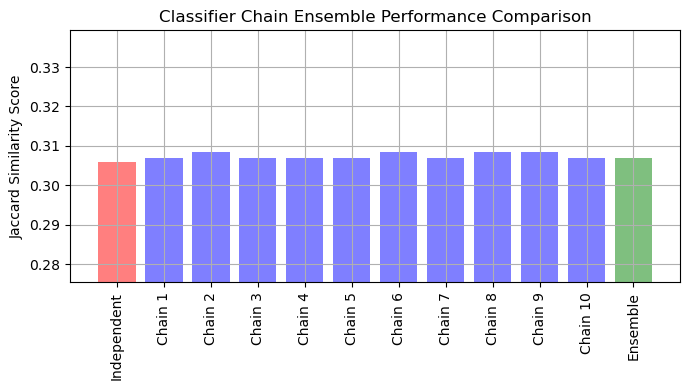

In [5]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()